### Load in Libraries and Data

In [1]:
from email.message import EmailMessage
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from datetime import date
import pandas as pd
import datetime
import requests
import sqlite3
import smtplib
import imghdr
import time
import csv
import os

In [2]:
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

url_amazon="https://www.amazon.com/Orgain-Organic-Protein-Powder-Vanilla/dp/B00J074W7Q/ref=sr_1_1_sspa?keywords=protein+powder&qid=1645311274&rdc=1&sr=8-1-spons&psc=1&spLa=ZW5jcnlwdGVkUXVhbGlmaWVyPUExQ1YxQzY5MUc1UzBPJmVuY3J5cHRlZElkPUEwMTgyODg3TlBZSUVYVFpGUTRHJmVuY3J5cHRlZEFkSWQ9QTA5MjkyNzIyRkdYRDFXTjgwWk9GJndpZGdldE5hbWU9c3BfYXRmJmFjdGlvbj1jbGlja1JlZGlyZWN0JmRvTm90TG9nQ2xpY2s9dHJ1ZQ=="
url_walgreens="https://www.walgreens.com/store/c/orgain-organic-plant-based-protein-powder/ID=prod6406416-product?skuId=sku6328567"
url_safeway="https://www.safeway.com/shop/product-details.960267339.html?cmpid=ps_swy_noc_ecom_goo_20200924_71700000073391208_58700007112590923_92700063970942228&gclid=CjwKCAiAx8KQBhAGEiwAD3EiPzhEY4sxvlTihlLLv7ao0t3I3JJ1nrm-vafmZBj5_XK5YC7l6xRBIhoCJfoQAvD_BwE&gclsrc=aw.ds"
url_orgain="https://orgain.com/collections/powders/products/organic-protein-plant-based-protein-powder"
url_riteaid="https://www.riteaid.com/shop/orgain-organic-plant-based-protein-powder-sweet-vanilla-bean-1-02-lb-0377759?gclid=CjwKCAiAx8KQBhAGEiwAD3EiP6FXTbxEkf_is9dWuHEU4iljAh_cs73MI_RsNxPF6A0UhZEaD0ocZxoCvIIQAvD_BwE"

### Define Functions to Scrape Each URL

In [3]:
def checkAmazonPrice(url_amazon):
    page = requests.get(url_amazon, headers=headers)
    amazon_soup = BeautifulSoup(page.content, "html.parser")
    amazon_soup2 = BeautifulSoup(amazon_soup.prettify(), "html.parser")
    title = amazon_soup.find(id='productTitle').get_text()
    price = amazon_soup.find(id="tp_price_block_total_price_ww").get_text()
    checkAmazonPrice.amazon_price = price.strip()[1:6]
    checkAmazonPrice.amazon_title = title.strip()
    return checkAmazonPrice.amazon_price, checkAmazonPrice.amazon_title

def checkWalgreensPrice(url_walgreens):
    page = requests.get(url_walgreens, headers=headers)
    walgreens_soup = BeautifulSoup(page.content, "html.parser")
    walgreens_soup2 = BeautifulSoup(walgreens_soup.prettify(), "html.parser")
    checkWalgreensPrice.walgreens_title = str(walgreens_soup2.find(id='productTitle').get_text()).partition('            ')[2].partition('\n')[0]
    price1 = str(walgreens_soup2.find(class_="product__price").get_text()).partition('\n\n               $\n              \n\n               ')[2].partition('\n              \n\n               ')[0]
    price2 = str(walgreens_soup2.find(class_="product__price").get_text()).rpartition('\n              \n')[0][-2:]
    checkWalgreensPrice.walgreens_price = price1 + '.' + price2
    return checkWalgreensPrice.walgreens_price, checkWalgreensPrice.walgreens_title

def checkOrgainPrice(url_orgain):
    page = requests.get(url_orgain, headers=headers)
    orgain_soup = BeautifulSoup(page.content, "html.parser")
    orgain_soup2 = BeautifulSoup(orgain_soup.prettify(), 'html.parser')
    checkOrgainPrice.orgain_title = str(orgain_soup2.find(class_="breadcrumb-active")).partition('         ')[2].rpartition('\n        ')[0]
    checkOrgainPrice.orgain_price = str(orgain_soup2.find(class_="product-form__price-price")).partition('$')[2].rpartition('\n')[0]
    return checkOrgainPrice.orgain_price, checkOrgainPrice.orgain_title

def checkSafewayPrice(url_safeway):
    page = requests.get(url_safeway, headers=headers)
    safeway_soup = BeautifulSoup(page.content, "html.parser")
    safeway_soup2 = BeautifulSoup(safeway_soup.prettify(), "html.parser")
    checkSafewayPrice.safeway_title = str(safeway_soup2.find("title")).partition('\n   ')[2].rpartition('\n')[0]
    checkSafewayPrice.safeway_price = str(safeway_soup2.findAll(type="application/ld+json")).partition("price")[2][4:].partition(',\n    "priceCurrency":')[0][:-1]
    return checkSafewayPrice.safeway_price, checkSafewayPrice.safeway_title

def checkRiteAidPrice(url_riteaid):
    page = requests.get(url_riteaid, headers=headers)
    riteaid_soup = BeautifulSoup(page.content, "html.parser")
    riteaid_soup2 = BeautifulSoup(riteaid_soup.prettify(), "html.parser")
    checkRiteAidPrice.riteaid_title = str(riteaid_soup2.find("title")).partition('<title>\n   ')[2].rpartition('\n')[0]
    checkRiteAidPrice.riteaid_price = str(riteaid_soup2.find(class_="price")).partition('$')[2].rpartition('\n')[0]
    return checkRiteAidPrice.riteaid_price, checkRiteAidPrice.riteaid_title

### Define Functions to Check the Prices all at Once, Calculate Price per Ounce, and Append these Prices to the Dataset

In [4]:
def checkPrices(url_amazon, url_walgreens, url_orgain, url_safeway, url_riteaid):
    checkAmazonPrice(url_amazon)
    checkWalgreensPrice(url_walgreens)
    checkOrgainPrice(url_orgain)
    checkSafewayPrice(url_safeway)
    checkRiteAidPrice(url_riteaid)

def determine_ozPrice():
    global amazon_ozPrice 
    amazon_ozPrice = float(checkAmazonPrice.amazon_price)/32.48
    
    global walgreens_ozPrice
    walgreens_ozPrice = float(checkWalgreensPrice.walgreens_price)/32.48
    
    global orgain_ozPrice
    orgain_ozPrice = float(checkOrgainPrice.orgain_price)/32.48
    
    global safeway_ozPrice
    safeway_ozPrice = float(checkSafewayPrice.safeway_price)/16.32
    
    global riteaid_ozPrice 
    riteaid_ozPrice = float(checkRiteAidPrice.riteaid_price)/16.32

def AppendUpdatedPrices():
    determine_ozPrice()
    conn = sqlite3.connect('pp_price_history.db')
    c = conn.cursor()

    c.execute("""CREATE TABLE IF NOT EXISTS pp_price_history (date string, product_ title string, company_name string, unit_price float, oz_price float)""")
    c.execute("INSERT INTO pp_price_history VALUES (?, ?, 'Amazon', ?, ?)", (date.today(), checkAmazonPrice.amazon_title, "${:,.2f}".format(float(checkAmazonPrice.amazon_price)), round(amazon_ozPrice,2)))
    c.execute("INSERT INTO pp_price_history VALUES (?, ?, 'Walgreens', ?, ?)", (date.today(), checkWalgreensPrice.walgreens_title, "${:,.2f}".format(float(checkWalgreensPrice.walgreens_price)), round(walgreens_ozPrice, 2))) 
    c.execute("INSERT INTO pp_price_history VALUES (?, ?, 'Orgain', ?, ?)", (date.today(), checkOrgainPrice.orgain_title, "${:,.2f}".format(float(checkOrgainPrice.orgain_price)), round(orgain_ozPrice, 2)))   
    c.execute("INSERT INTO pp_price_history VALUES (?, ?, 'Safeway', ?, ?)", (date.today(), checkSafewayPrice.safeway_title, "${:,.2f}".format(float(checkSafewayPrice.safeway_price)), round(safeway_ozPrice, 2))) 
    c.execute("INSERT INTO pp_price_history VALUES (?, ?, 'Rite Aid', ?, ?)", (date.today(), checkRiteAidPrice.riteaid_title, "${:,.2f}".format(float(checkRiteAidPrice.riteaid_price)), round(riteaid_ozPrice, 2)))
    
    conn.commit()
    conn.close()

### Define a Function to Create A Bar Chart Using a Database Tracking Which Company has the Lowest Price

In [5]:
def createBarChart():
    #Update Price History and Calculate the Week's Lowest Price
    conn = sqlite3.connect('pp_price_history.db', timeout=10)
    c = conn.cursor()

    c.execute("""CREATE TABLE IF NOT EXISTS lowest_prices_data (
                company_name string,
                week_count int,
                colors_codes string
                )""")

    #c.execute("INSERT INTO lowest_prices_data VALUES ('Amazon', 0, '#7CFFC4'), ('Orgain', 0, '#FF729F'), ('Walgreens', 0, '#F75C03'), ('Safeway', 0, '#00CC66'), ('Rite Aid', 0, '#92C6FF')")
    
    global week_counter
    global lowest_company
    week_counter = sorted([amazon_ozPrice, walgreens_ozPrice, orgain_ozPrice, safeway_ozPrice, riteaid_ozPrice])
    
    #Calculates Company with Lowest Price and Inserts them into the Database
    if week_counter[0] == amazon_ozPrice:
        c.execute("""UPDATE lowest_prices_data SET week_count = week_count + 1 WHERE company_name = 'Amazon'""")
        lowest_company = 'Amazon'
    elif week_counter[0] == orgain_ozPrice:
        c.execute("""UPDATE lowest_prices_data SET week_count = week_count +1 WHERE company_name = 'Orgain'""")
        lowest_company = 'Orgain'
    elif week_counter[0] == walgreens_ozPrice:
        c.execute("""UPDATE lowest_prices_data SET week_count = week_count +1 WHERE company_name = 'Walgreens'""")
        lowest_company = 'Walgreens'
    elif week_counter[0] == safeway_ozPrice:
        c.execute("""UPDATE lowest_prices_data SET week_count = week_count +1 WHERE company_name = 'Safeway'""")
        lowest_company = 'Safeway'
    elif week_counter[0] == riteaid_ozPrice:
        c.execute("""UPDATE lowest_prices_data SET week_count = week_count +1 WHERE company_name = 'Rite Aid'""")
        lowest_company = 'Rite Aid'

    #Transform Database to Dataframe
    bar_df = pd.read_sql_query("SELECT * FROM lowest_prices_data", conn)
    bar_df = bar_df.sort_values('week_count', ascending=False)

    #Create Bar Chart
    plt.figure(figsize=(8,5), dpi=250)
    low_chart = plt.bar(bar_df['company_name'], bar_df['week_count'])
    plt.style.use('seaborn-pastel')

    #Set Corresponding Bar Colors and Titles
    colors_list = bar_df['colors_codes'].tolist()
    for bar in low_chart:
        bar.set_color(colors_list.pop(0))
        
    plt.title("Lowest Prices Per Company (by Ounce Price)")
    plt.xlabel("Company Names")
    plt.ylabel("Amount of Weeks with the Lowest Price")
    plt.savefig('proteinpowderBarChart.png')
    plt.show()
    
    conn.commit()
    conn.close()

### Line Chart

In [12]:
def createLineChart():
    conn = sqlite3.connect('pp_price_history.db')
    c = conn.cursor()

    #Calculate the Data and Retrieve it from Database by Converting it to Dataframes
    global pricehistory_df
    pricehistory_df = pd.read_sql_query("SELECT oz_price FROM pp_price_history", conn)
    amazon_df = pd.read_sql_query("SELECT * FROM pp_price_history WHERE company_name == 'Amazon'", conn)
    walgreens_df = pd.read_sql_query("SELECT * FROM pp_price_history WHERE company_name == 'Walgreens'", conn)
    orgain_df = pd.read_sql_query("SELECT * FROM pp_price_history WHERE company_name == 'Orgain'", conn)
    safeway_df = pd.read_sql_query("SELECT * FROM pp_price_history WHERE company_name == 'Safeway'", conn)
    riteaid_df = pd.read_sql_query("SELECT * FROM pp_price_history WHERE company_name == 'Rite Aid'", conn)

    amazon_x = amazon_df['date']
    amazon_y = amazon_df['oz_price']

    walgreens_x = walgreens_df['date']
    walgreens_y = walgreens_df['oz_price']

    orgain_x = orgain_df['date']
    orgain_y = orgain_df['oz_price']

    safeway_x = safeway_df['date']
    safeway_y = safeway_df['oz_price']

    riteaid_x = riteaid_df['date']
    riteaid_y = riteaid_df['oz_price']
    
    #Create Line Chart
    line1, = plt.plot(amazon_x, amazon_y, label='Amazon', color='#7CFFC4')
    line2, = plt.plot(walgreens_x, walgreens_y, label='Walgreens', color='#F75C03')
    line3, = plt.plot(orgain_x, orgain_y, label='Orgain', color='#FF729F')
    line4, = plt.plot(safeway_x, safeway_y, label='Safeway', color='#00CC66')
    line5, = plt.plot(riteaid_x, riteaid_y, label='Rite Aid', color='#92C6FF')

    
    plt.style.use('seaborn-pastel')
    plt.title("Price History")
    plt.xlabel("Dates")
    plt.ylabel("Ounce Price")
    plt.legend([line1, line2, line3, line4, line5], ['Amazon','Walgreens','Orgain', 'Safeway', 'Rite Aid'])
    plt.savefig('proteinpowderPriceHistory.png')
    plt.figure(figsize=(8,5), dpi=250)
    plt.show()
    
    conn.commit()
    conn.close()

In [7]:
def sendinfoemail():
    EMAIL_ADDRESS = os.environ.get('EMAIL_ADDRESS')
    EMAIL_PASSWORD = os.environ.get('EMAIL_PASSWORD')
    average = (round(pricehistory_df['oz_price'].mean(), 2))
    msg = EmailMessage()
    msg['Subject'] = 'Protein Powder Price Checker'
    msg['From'] = EMAIL_ADDRESS
    msg['To'] = 'turkey.mat@gmail.com'
    msg.set_content(f'What up CHAMP? You ready to get some GAINS? The cheapest price for Orgain Protein Powder this week is ${round(week_counter[0],2)} per ounce and is offered by {lowest_company}. All prices are as follows:\n             Amazon : ${round(amazon_ozPrice,2)} per ounce\n             Walgreens : ${round(walgreens_ozPrice,2)} per ounce \n             Rite Aid : ${round(riteaid_ozPrice,2)} per ounce\n             Orgain : ${round(orgain_ozPrice,2)} per ounce \n             Safeway : ${round(safeway_ozPrice,2)} per ounce\n             Average : ${average} per ounce')

    # msg.add_alternative("""\
    # <!DOCTYPE html>
    # <html>
    #     <body>
    #         <p>Hello!</p>
    #     </body>
    # </html
    # """, subtype='html')

    files = ['proteinpowderPriceHistory.png', 'proteinpowderBarChart.png']

    for file in files:
        with open(file, 'rb') as f:
            file_data = f.read()
            file_type = imghdr.what(f.name)
            file_name = f.name

        msg.add_attachment(file_data, maintype='image', subtype=file_type, filename=file_name)

    with smtplib.SMTP('smtp.gmail.com', 587) as smtp:
        smtp.ehlo()
        smtp.starttls()
        smtp.ehlo()

        smtp.login(EMAIL_ADDRESS, EMAIL_PASSWORD)

        smtp.send_message(msg)

def sendErrorEmail():
    EMAIL_ADDRESS = os.environ.get('EMAIL_ADDRESS')
    EMAIL_PASSWORD = os.environ.get('EMAIL_PASSWORD')

    msg = EmailMessage()
    msg['Subject'] = 'Protein Powder Price Checker'
    msg['From'] = EMAIL_ADDRESS
    msg['To'] = 'turkey.mat@gmail.com'
    msg.set_content(f'Something has gone wrong with the automatic updates. Please check to make sure no product pages changed. Error: {exceptionError}')

    # msg.add_alternative("""\
    # <!DOCTYPE html>
    # <html>
    #     <body>
    #         <p>Hello!</p>
    #     </body>
    # </html
    # """, subtype='html')

    with smtplib.SMTP('smtp.gmail.com', 587) as smtp:
        smtp.ehlo()
        smtp.starttls()
        smtp.ehlo()

        smtp.login(EMAIL_ADDRESS, EMAIL_PASSWORD)

        smtp.send_message(msg)

### Define and Run the Entire Program

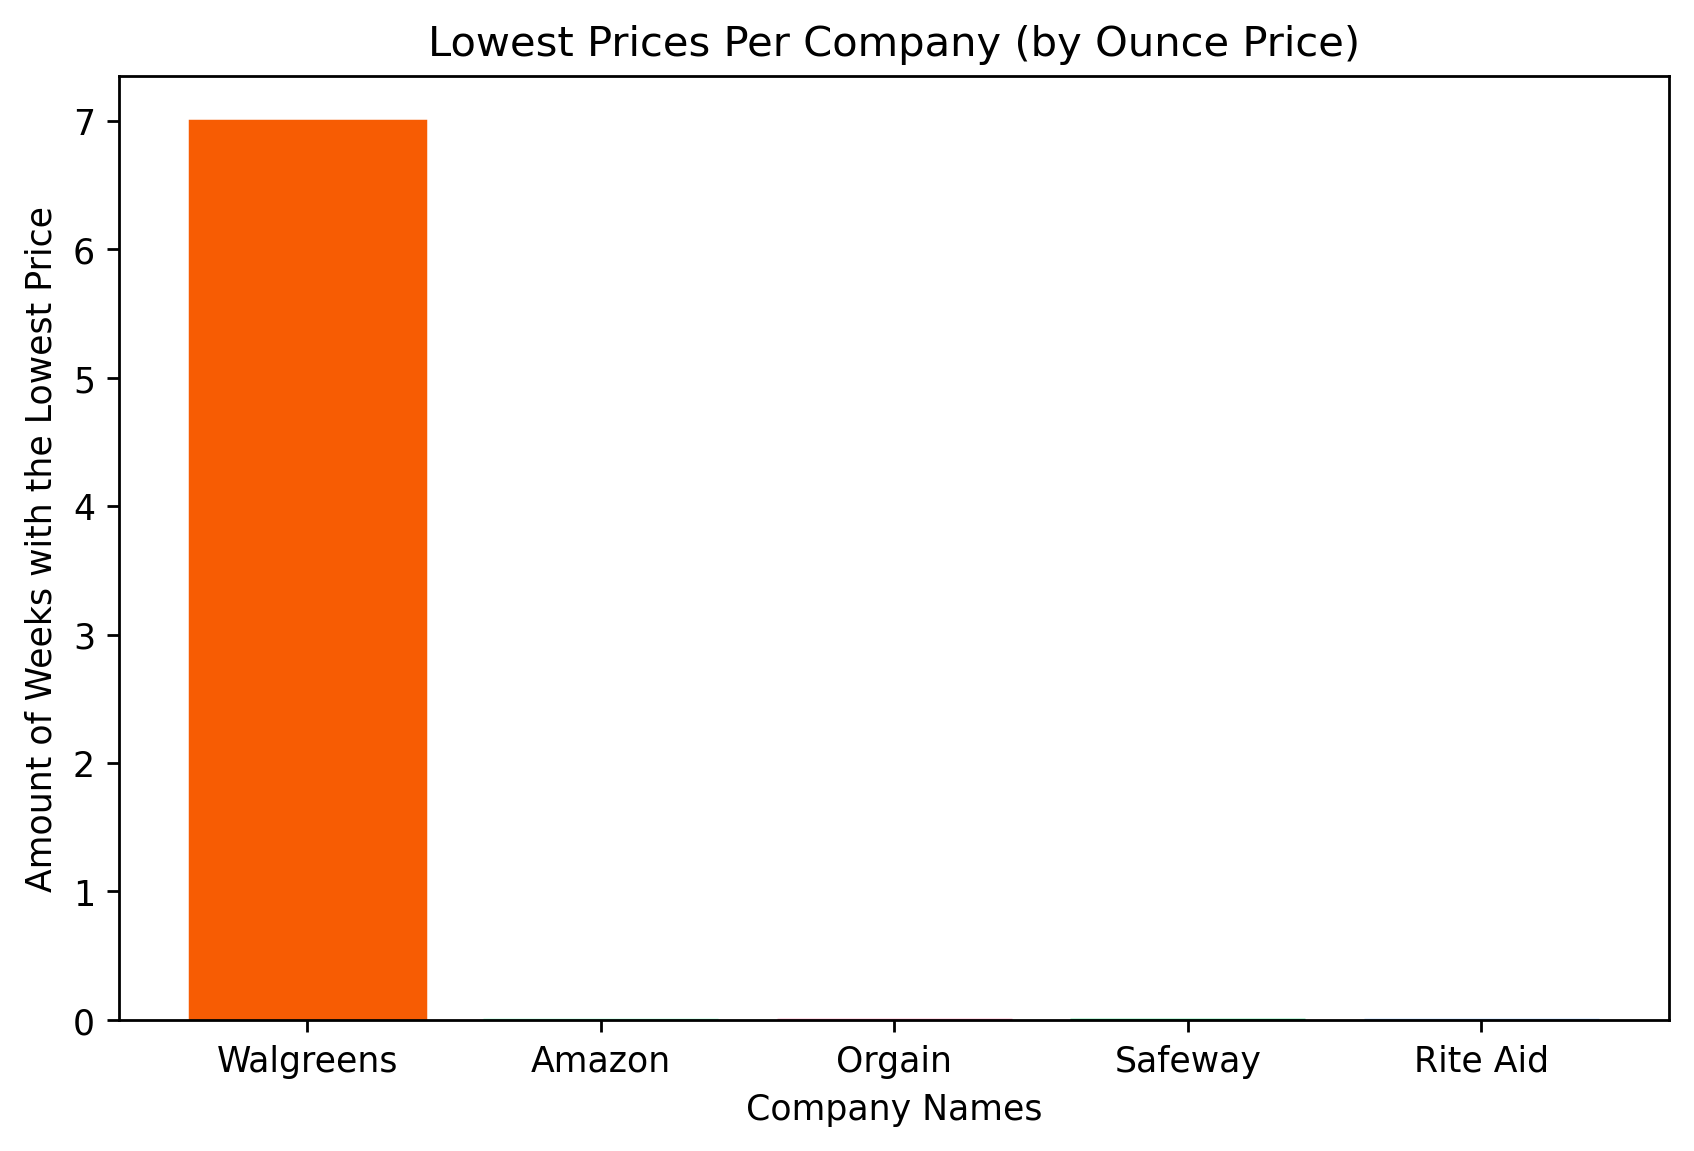

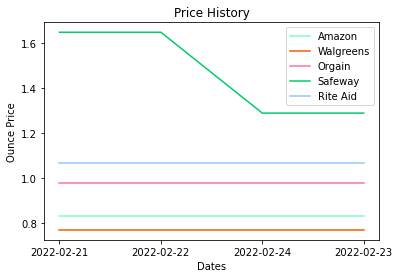

<Figure size 2000x1250 with 0 Axes>

In [13]:
def runAllOperations():
    try: 
        checkPrices(url_amazon, url_walgreens, url_orgain, url_safeway, url_riteaid)
        determine_ozPrice()
        AppendUpdatedPrices()
        
        if os.path.exists('proteinpowderPriceHistory.png'):
            os.remove('proteinpowderPriceHistory.png')
        
        if os.path.exists('proteinpowderBarChart.png'):
            os.remove('proteinpowderBarChart.png')
        
        createBarChart()
        createLineChart()
        sendinfoemail()
    except Exception as e:
        global exceptionError
        exceptionError = e
        sendErrorEmail()

runAllOperations()